# Example Serial Position Cells Visualization

This notebook contains plots of example cells from the serial position analysis. 

In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from scipy.stats import sem, ttest_rel

from convnwb.io import load_nwbfile
from convnwb.io import get_files

from spiketools.measures.trials import compute_segment_frs
from spiketools.measures.spikes import compute_firing_rate
from spiketools.measures.conversions import convert_times_to_rates
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import compute_surrogate_stats
from spiketools.utils import set_random_seed
from spiketools.utils.base import select_from_list
from spiketools.utils.data import compute_range
from spiketools.utils.extract import (get_range, get_value_by_time, get_values_by_time_range,
                                      get_values_by_times, threshold_spikes_by_times)
from spiketools.utils.epoch import (epoch_data_by_range, epoch_spikes_by_segment, 
                                    epoch_spikes_by_range, epoch_spikes_by_event)
from spiketools.plts.data import plot_bar
from spiketools.plts.trials import plot_rasters
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.style import drop_spines
from spiketools.plts.utils import make_axes, save_figure, make_grid, get_grid_subplot

In [3]:
import sys
sys.path.append('../code')

from models import *
from utils import *
from plts import *

In [4]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [5]:
# Define the base data folder
data_folder = '/Users/tom/Data/JacobsLab/WVTH/nwb'
#data_folder = '/data12/jacobs_lab/WVTH/nwb'
#data_folder = '/Users/clairehan/Documents/Data/JacobsLab/WVTH/nwb'

In [6]:
# Define session information
session = {
    'experiment' : 'THF',
    'subject' : 'wv001',
    'session' : 2
}

In [7]:
# Set which example unit to extract
uind = 68

In [8]:
# Define occupancy settings: minimum required occupancy (in seconds) & speed threshold
min_occ = 1
speed_thresh = 5e-6
time_thresh = 0.25

In [9]:
# Shuffle Settings
shuffle_approach = 'CIRCULAR'  # 'CIRCULAR', 'BINCIRC'
n_surrogates = 1000

if shuffle_approach == 'CIRCULAR':
    shuffle_kwargs = {}
if shuffle_approach == 'BINCIRC':
    shuffle_kwargs = {}
    #shuffle_kwargs = {'shuffle_min' : 20000}

In [10]:
# Set which analysis method to run
METHOD = 'ANOVA'  # 'SEGMENT' / 'ANOVA'

## Load data

In [11]:
# Get the list of NWB files
nwbfiles = get_files(data_folder)

In [12]:
# Load example NWB file
nwbfile = load_nwbfile(session, data_folder)

In [13]:
# Get the list of NWB files running THO, THF respectively
nwbfiles_THF = get_files(data_folder, select='THF')
nwbfiles_THO = get_files(data_folder, select='THO')

### Get trial data

In [14]:
# Get the number of trials
n_trials = len(nwbfile.trials)
print('Number of trials: {}'.format(n_trials))

Number of trials: 24


In [15]:
nav_starts = nwbfile.trials.navigation_start[:]
nav_stops = nwbfile.trials.navigation_stop[:]
chest_openings = nwbfile.trials['chest_opening_time'][:]
ch_openings_all = np.array(chest_openings).reshape(-1,1)

### Get spike data

In [16]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [17]:
# Get spikes
spikes = nwbfile.units.get_unit_spike_times(uind)

In [18]:
# Define the segment times of interest
seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
# chest_trial_number = np.array(list(range(len(chest_trials)))).reshape(n_trials,4)

## One example serial position cell

In [19]:
# Compute the time duration in each serial position
segment_frs = compute_segment_frs(spikes, seg_times)
seg_interval = np.zeros([seg_times.shape[0], 4])
for ind in range(seg_times.shape[0]):
    seg_interval[ind, :] = (np.diff(seg_times[ind])).tolist()

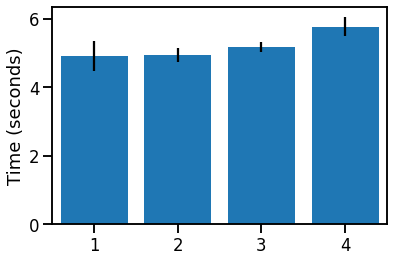

In [20]:
plot_bar(seg_interval.mean(0), [0, 1, 2, 3], xticks=[0,1,2,3], xticklabels=[1,2,3,4], 
         yerr=sem(seg_interval, 0), ylabel='Time (seconds)')

In [21]:
# Compute spike count in each serial position segment
tseg_count = np.zeros([seg_times.shape[0], 4])
for ind, time in enumerate(seg_times):
    segment_spikes = epoch_spikes_by_segment(spikes, time)
    tseg_count[ind, :] = np.array([len(segment_spikes[0]), len(segment_spikes[1]),
                                   len(segment_spikes[2]), len(segment_spikes[3])])

seg_counts = np.sum(tseg_count, 0)

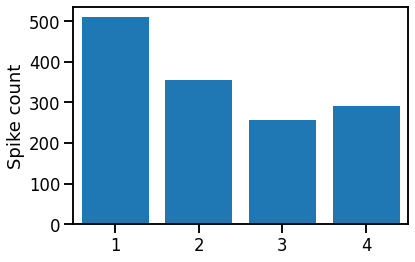

In [22]:
plot_bar(seg_counts, [0,1,2,3], xticks=[0,1,2,3], xticklabels=[1,2,3,4], ylabel='Spike count')

#### Normalized raster plot 

In [23]:
trials_sp = epoch_spikes_by_range(spikes, nav_starts, np.array(chest_openings)[:,3], reset=False)
t_spikes = np.concatenate(trials_sp).ravel()

In [24]:
ts_s0 = normalize_spikes_by_segment(t_spikes, nav_starts, np.array(chest_openings)[:,0], (0, 1))
ts_s1 = normalize_spikes_by_segment(t_spikes, np.array(chest_openings)[:,0], np.array(chest_openings)[:,1], (1, 2))
ts_s2 = normalize_spikes_by_segment(t_spikes, np.array(chest_openings)[:,1], np.array(chest_openings)[:,2], (2, 3))
ts_s3 = normalize_spikes_by_segment(t_spikes, np.array(chest_openings)[:,2], np.array(chest_openings)[:,3], (3, 4))

In [25]:
spikes_trial = [np.hstack([ts_s0[ind], ts_s1[ind], ts_s2[ind], ts_s3[ind]]) for ind in range(n_trials)]

#### Surrogate Distribution

In [26]:
# Create shuffled time series for comparison
times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)

In [27]:
# Create dataframe
df = create_df_serial(segment_frs)

In [28]:
# Fit the ANOVA, and get f-value
f_val = fit_anova_serial(df)

In [29]:
# Compute measures across shuffled time series for comparison
surrogates = np.zeros(n_surrogates)
for ind, shuffle in enumerate(times_shuffle):
    surr_segment_frs = compute_segment_frs(shuffle, seg_times)
    df = create_df_serial(surr_segment_frs)
    surrogates[ind] = fit_anova_serial(df)

In [30]:
# Compute surrogate statistics
p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=True)

p-value: 0.01
z-score: 3.67


## Create report for significant cell

In [31]:
name = nwbfile.session_id + '_U' + str(uind).zfill(2)

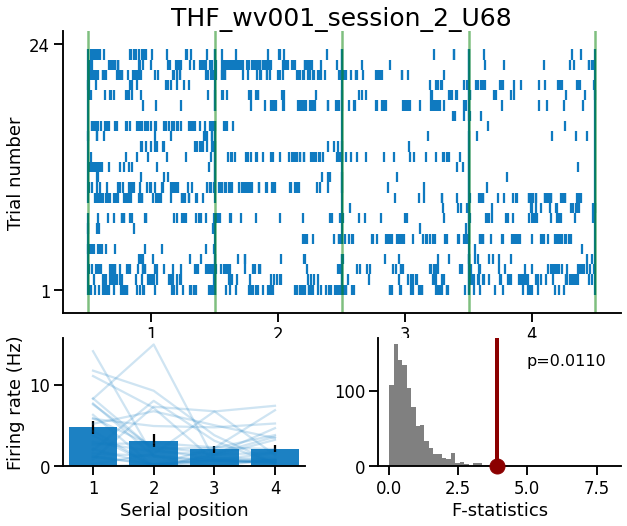

In [32]:
grid = make_grid(3, 2, figsize=(10, 8), wspace=0.3)
plot_rasters(spikes_trial, vline=[0, 1, 2, 3, 4], show_axis=True, 
             ylabel="Trial number", colors='#0F7AC0', xticks=[0.5, 1.5, 2.5, 3.5], 
             yticks=[0, len(spikes_trial)], xticklabels=[1,2,3,4], yticklabels=[1, len(spikes_trial)],
             ax=get_grid_subplot(grid, slice(0,2), slice(0,2)))

plt.title(name, fontsize=25)
plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.95, color="#0F7AC0", 
         ax=get_grid_subplot(grid, 2, 0), xlabel='Serial position', ylabel='Firing rate (Hz)')

for ind in range(len(segment_frs[:,0])): 
    get_grid_subplot(grid, 2, 0).plot(['1','2','3','4'], segment_frs[ind], color='#0F7AC0', alpha=0.2)

plot_surrogates(surrogates, 50, f_val, p_val, ax=get_grid_subplot(grid, 2, 1))
get_grid_subplot(grid, 2, 1).set(xlabel='F-statistics')

drop_spines(get_grid_subplot(grid, slice(0,2), slice(0,2)), ['top', 'right'])
drop_spines(get_grid_subplot(grid, 2, 0), ['top', 'right'])
drop_spines(get_grid_subplot(grid, 2, 1), ['top', 'right'])

# save_figure('fig2_serial_face'+'.svg','/Users/clairehan/Desktop/paper_fig', close=False, bbox_inches='tight')

## All significant target cells

In [33]:
# # Load & merge the results sheets of THF & THO
# df_THF = pd.read_csv("/Users/clairehan/Desktop/THF_combined_all_results.csv")
# # df_THO = pd.read_excel("/Users/Claire_han/Desktop/research/WVTH/THO_all_results.xlsx")
# # df = df_THF.append(df_THO)

In [34]:
# # Create a dataframe for significant spatial target cells
# df_sp = df_THF[df_THF.is_sp_cell]
# df_overlap = df_sp[df_sp.is_baseline_cell]
# df_overlap

In [35]:
# for nwbfile in nwbfiles:
#     nwbfile, io = load_nwbfile(nwbfile, data_folder, return_io=True)
#     name = nwbfile.session_id
    
#     # Get indices of significant target cell from each session
#     inds = np.where(df_overlap.session_id == name)[0]
#     inds_uid = df_overlap.uid.iloc[inds].values
    
#     # Get trial information 
#     n_trials = len(nwbfile.trials)
#     nav_starts = nwbfile.trials.navigation_start[:]
#     nav_stops = nwbfile.trials.navigation_stop[:]
#     chest_openings = nwbfile.trials['chest_opening_time'][:]
#     ch_openings_all = np.array(chest_openings).reshape(-1,1)
    
#     # Define the segment times of interest
#     seg_times = np.insert(np.array(chest_openings), 0, nav_starts, axis=1)
    
#     for ind in inds_uid: 
#         name_ind = nwbfile.session_id + '_U' + str(ind).zfill(2)
        
#         # Get spike data for each significant unit
#         spikes = nwbfile.units.get_unit_spike_times(ind)
        
#         # Compute firing rate per spatial target bin
#         segment_frs = compute_segment_frs(spikes, seg_times)
        
#         # Compute the time spent in each segment
#         seg_interval = np.zeros([seg_times.shape[0], 4])
#         for ind in range(seg_times.shape[0]):
#             seg_interval[ind, :] = (np.diff(seg_times[ind])).tolist()
        
#         # Count the number of spikes in each segment
#         tseg_count = np.zeros([seg_times.shape[0], 4])
#         for ind, time in enumerate(seg_times):
#             segment_spikes = epoch_spikes_by_segment(spikes, time)
#             tseg_count[ind, :] = np.array([len(segment_spikes[0]), len(segment_spikes[1]), len(segment_spikes[2]), 
#                                            len(segment_spikes[3])])
#         seg_counts = np.sum(tseg_count, 0)
        
#         # Normalize the spikes in each segment in unit time
#         trials_sp = epoch_spikes_by_range(spikes, nav_starts, np.array(chest_openings)[:,3], reset=False)
#         t_spikes = np.concatenate(trials_sp).ravel()
        
#         s0_spikes = normalize_segment_spikes(t_spikes, nav_starts, np.array(chest_openings)[:,0], (0, 1))
#         s1_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,0], 
#                                              np.array(chest_openings)[:,1], (1, 2))
#         s2_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,1], 
#                                              np.array(chest_openings)[:,2], (2, 3))
#         s3_spikes = normalize_segment_spikes(t_spikes, np.array(chest_openings)[:,2], 
#                                              np.array(chest_openings)[:,3], (3, 4))
        
#         spikes_trial = [np.hstack([s0_spikes[ind], s1_spikes[ind], s2_spikes[ind], s3_spikes[ind]])
#                     for ind in range(n_trials)]
        
#         # Create shuffled time series for comparison
#         times_shuffle = shuffle_spikes(spikes, shuffle_approach, n_surrogates, **shuffle_kwargs)
        
#         # Create dataframe
#         df = create_df_serial(segment_frs)
        
#         # Fit the ANOVA, and get f-value
#         f_val = fit_anova_serial(df)
        
#         # Compute measures across shuffled time series for comparison
#         surrogates = np.zeros(n_surrogates)
#         for ind, shuffle in enumerate(times_shuffle):
#             segment_frs = compute_segment_frs(shuffle, seg_times)
#             df = create_df_serial(segment_frs)
#             surrogates[ind] = fit_anova_serial(df)
        
#         # Compute surrogate statistics
#         p_val, z_score = compute_surrogate_stats(f_val, surrogates, verbose=False)
        
#         # Plot the example serial position cell
#         grid = make_grid(3, 2, figsize=(8, 12), wspace=0.3, )
#         plot_rasters(spikes_trial, vline=[0, 1, 2, 3, 4], show_axis=True, ax=get_grid_subplot(grid, slice(0,2), slice(0,2)),
#                           ylabel="Trial number", colors='C0',
#                           xticks=[0.5, 1.5, 2.5, 3.5], yticks=range(0,len(spikes_trial)), xticklabels=[0,1,2,3])
#         plt.yticks(fontsize=15)
#         plt.title(name_ind)
#         plot_bar(segment_frs.mean(0), [0, 1, 2, 3], yerr=sem(segment_frs, 0), alpha=0.95, color="C0", 
#                  ax=get_grid_subplot(grid, 2, 0), xlabel='Serial position', ylabel='Firing rate (Hz)')
#         for ind in range(len(segment_frs[:,0])): 
#             get_grid_subplot(grid, 2, 0).plot(['0','1','2','3'], segment_frs[ind], color='C0', alpha=0.2)
#         # get_grid_subplot(grid, 2, 0).set(ylim=[0,8])

#         plot_surr_stats(surrogates, f_val, p_val, 50, ax=get_grid_subplot(grid, 2, 1))
#         get_grid_subplot(grid, 2, 1).set(xlabel='F-statistics')

#         # Drop after spiketools update
#         get_grid_subplot(grid, slice(0,2), slice(0,2)).spines.right.set_visible(False)
#         get_grid_subplot(grid, slice(0,2), slice(0,2)).spines.top.set_visible(False)
#         get_grid_subplot(grid, 2, 0).spines.right.set_visible(False)
#         get_grid_subplot(grid, 2, 0).spines.top.set_visible(False)
#         get_grid_subplot(grid, 2, 1).spines.right.set_visible(False)
#         get_grid_subplot(grid, 2, 1).spines.top.set_visible(False)
        
# #         save_figure(name_ind + '.pdf', '/Users/clairehan/Desktop/poster_figures/THF_overall_serial&baseline', close=True, bbox_inches='tight')